In [1]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

In [2]:
def tanh(x):
    return np.tanh(x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def softmax(x):
    eps = 1e-8
    out = np.exp(x - np.max(x, axis=1).reshape(-1, 1))
    return out / (np.sum(out, axis=1).reshape(-1, 1) + eps)

In [3]:
class NN(object):

    def __init__(self, in_dim=None, h_dim=None, out_dim=None, w1=None, b1=None, w2=None, b2=None):
        self.w1 = np.random.randn(in_dim, h_dim) if w1 is None else w1
        self.b1 = np.random.randn(1, h_dim) if b1 is None else b1
        self.w2 = np.random.randn(h_dim, out_dim) if w2 is None else w2
        self.b2 = np.random.randn(1, out_dim) if b2 is None else b2

    def loss(self, x, y):  # using cross entropy as loss function
        eps = 1e-8
        return -(np.multiply(y, np.log(self.predict(x)))).mean()

    def predict(self, x):
        o1 = sigmoid(x.dot(self.w1) + self.b1)
        return softmax(o1.dot(self.w2) + self.b2)

In [7]:
class EvolutionaryAlgorithm(object):

    def __init__(self):
        self.pop_num = 50
        self.elitism_num = self.pop_num // 5
        self.gen_num = 1000
        self.mutate_rate = 0.1

    def cross_over(self, w1, w2):
        # CROSSOVER
        mask = np.random.uniform(0, 1, w1.shape)
        return (mask > 0.5) * w1 + (mask <= 0.5) * w2

    def mutate(self, w):
        mask = np.random.uniform(0, 1, w.shape)
        mutate_multiplier = np.random.randn(w.shape[0], w.shape[1])
        w += w * (mask <= self.mutate_rate) * mutate_multiplier

        mutate_range = 3  # prevent too large or small
        w[w > mutate_range] = mutate_range
        w[w < -mutate_range] = -mutate_range

    def evolve(self, old_pop, x, y):
        eps = 1e-8
        fitness = np.array([1 / (p.loss(x, y) + eps) for p in old_pop])
        fitness = fitness / fitness.sum()
        top = np.argsort(fitness)[-1:-self.elitism_num - 1:-1]
        new_pop = [old_pop[idx] for idx in top]
        for i in range(self.pop_num - self.elitism_num):
            # SELECTION by probabilities (fitness)
            idxes = np.random.choice(self.pop_num, 2, p=fitness)
            a = old_pop[idxes[0]]
            b = old_pop[idxes[1]]
            # CROSSOVER
            w1 = self.cross_over(a.w1, b.w1)
            b1 = self.cross_over(a.b1, b.b1)
            w2 = self.cross_over(a.w2, b.w2)
            b2 = self.cross_over(a.b2, b.b2)
            # MUTATION
            self.mutate(w1)
            self.mutate(b1)
            self.mutate(w2)
            self.mutate(b2)
            new_pop.append(NN(w1=w1, b1=b1, w2=w2, b2=b2))

        loss = [p.loss(x, y) for p in new_pop]
        return new_pop, loss

    def run(self, x, y):
        label_num = len(np.unique(y))
        labels = np.zeros((x.shape[0], label_num))
        labels[np.arange(x.shape[0]), y] = 1

        population = [NN(in_dim=x.shape[1], h_dim=32, out_dim=label_num)
                      for _ in range(self.pop_num)]
        losslog = []
        for i in range(self.gen_num):
            population, loss = self.evolve(population, x, labels)
            losslog.append([max(loss), np.mean(loss), min(loss)])
            print("Gen {} max:{} min:{} mean:{}".format(
                i, max(loss), min(loss), np.mean(loss)))
        losslog = np.array(losslog)
        plt.plot(losslog[:, 0])
        plt.plot(losslog[:, 1])
        plt.plot(losslog[:, 2])
        plt.legend(('max', 'mean', 'best'), loc='best')
        plt.title('loss over generation')
        plt.show()
        return population[np.argmin(loss)]

<Figure size 432x288 with 0 Axes>

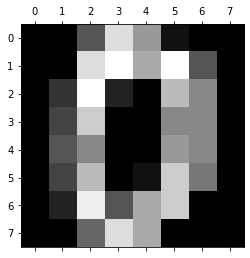

Gen 0 max:0.9203796545700063 min:0.47757006657351087 mean:0.6301711958004639
Gen 1 max:1.0804724464628508 min:0.43188931361586586 mean:0.6255378993223645
Gen 2 max:0.8761801966732531 min:0.43188931361586586 mean:0.5995469783655197
Gen 3 max:1.2092859996253735 min:0.4126989915301559 mean:0.6200873050985507
Gen 4 max:1.1027475593013154 min:0.4126989915301559 mean:0.6262468233193379
Gen 5 max:0.9981385160266378 min:0.4126989915301559 mean:0.6096478014948131
Gen 6 max:1.0774303783569519 min:0.406808338918355 mean:0.5798353164548888
Gen 7 max:0.9610190655670712 min:0.406808338918355 mean:0.5725657577601273
Gen 8 max:1.0570063645570094 min:0.406808338918355 mean:0.596318789603953
Gen 9 max:1.092432101823056 min:0.406808338918355 mean:0.6217814749955941
Gen 10 max:0.9100472001432282 min:0.406808338918355 mean:0.5907843440118092
Gen 11 max:1.0046692378557645 min:0.406808338918355 mean:0.6189292444967185
Gen 12 max:0.8037337227115215 min:0.406808338918355 mean:0.5755747385030964
Gen 13 max:0.87

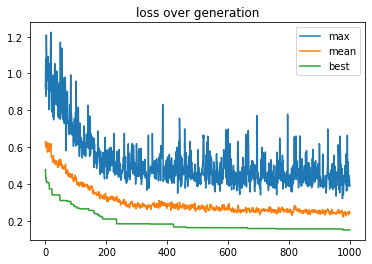

0.4682080924855491


In [12]:
data = load_digits()

plt.gray()
plt.matshow(data.images[0])
plt.show()

x = data.data
y = data.target

test_ratio = 0.2
test_split = np.random.uniform(0, 1, len(x))
train_x = x[test_split >= test_ratio]
test_x = x[test_split < test_ratio]
train_y = y[test_split >= test_ratio]
test_y = y[test_split < test_ratio]

ea = EvolutionaryAlgorithm()
model = ea.run(train_x, train_y)
res = model.predict(test_x)
print(sum(yi == np.argmax(y_hat)
for y_hat, yi in zip(res, test_y)) / test_y.shape[0])

<Figure size 432x288 with 0 Axes>

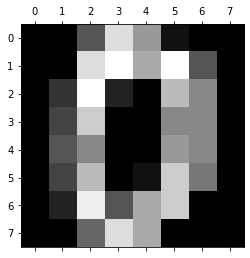